# Imports

In [8]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import roc_auc_score

# Paths

In [9]:
IMAGES_DIR = Path("/home/usrs/hnoel/RAVIR_dataset/train/training_images")
GT_DIR     = Path("/home/usrs/hnoel/RAVIR_dataset/train/training_masks")
PRED_DIR   = Path("/home/usrs/hnoel/IIC/nnUNetv2/first_experience")

In [10]:
# Save files directory

save_dir_5_samples = Path("/home/usrs/hnoel/IIC/nnUNetv2/first_experience/visu_5_samples")
save_dir_5_samples.mkdir(parents=True, exist_ok=True)

# Config classes

In [15]:
CLASS_BG    = 0
CLASS_VEIN  = 128
CLASS_ART   = 255

VESSEL_CLASSES = [CLASS_ART, CLASS_VEIN]
CLASS_NAMES = {
    CLASS_ART:  "Artery",
    CLASS_VEIN: "Vein"
}

CLASS_ARTERY = 255
CLASS_VEIN   = 128
VESSEL_CLASSES = [CLASS_ARTERY, CLASS_VEIN]

# Load

In [12]:
def load_img(path):
    return np.array(Image.open(path).convert("L"))

def load_mask(path):
    return np.array(Image.open(path))

# Metrics

In [13]:
def dice_per_image(pred, target, value):
    eps = 1e-7
    p = (pred == value)
    t = (target == value)
    intersection = np.logical_and(p, t).sum()
    union = p.sum() + t.sum() + eps
    if union == eps:
        return np.nan
    return 2 * intersection / union


def iou_per_image(pred, target, value):
    eps = 1e-7
    p = (pred == value)
    t = (target == value)
    inter = np.logical_and(p, t).sum()
    union = np.logical_or(p, t).sum() + eps
    if union == eps:
        return np.nan
    return inter / union


def auc_per_image_binary(pred_mask, gt_mask, class_value):
    """
    pred_mask: tableau bool {0,1}
    gt_mask:   tableau bool {0,1}
    """
    y_true = (gt_mask == class_value).astype(np.uint8).ravel()
    y_score = (pred_mask == class_value).astype(np.float32).ravel()

    if y_true.mean() == 0 or y_true.mean() == 1:
        return np.nan

    return roc_auc_score(y_true, y_score)

# Listing of commun files

In [14]:
gt_dict   = {f.name: f for f in GT_DIR.glob("*.png")}
pred_dict = {f.name: f for f in PRED_DIR.glob("*.png")}
img_dict  = {f.name: f for f in IMAGES_DIR.glob("*.png")}

common_names = sorted(set(gt_dict) & set(pred_dict) & set(img_dict))
print("Total matching cases:", len(common_names))

Total matching cases: 23


# Print 5 random exemples

🖼️  Image : IR_Case_055.png


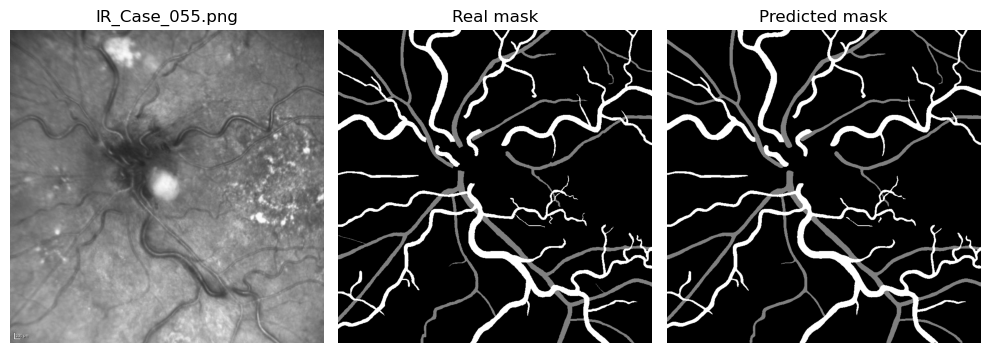

🖼️  Image : IR_Case_020.png


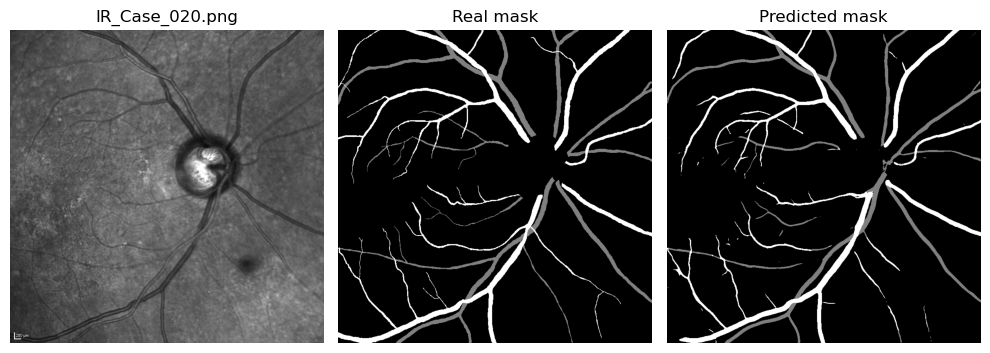

🖼️  Image : IR_Case_011.png


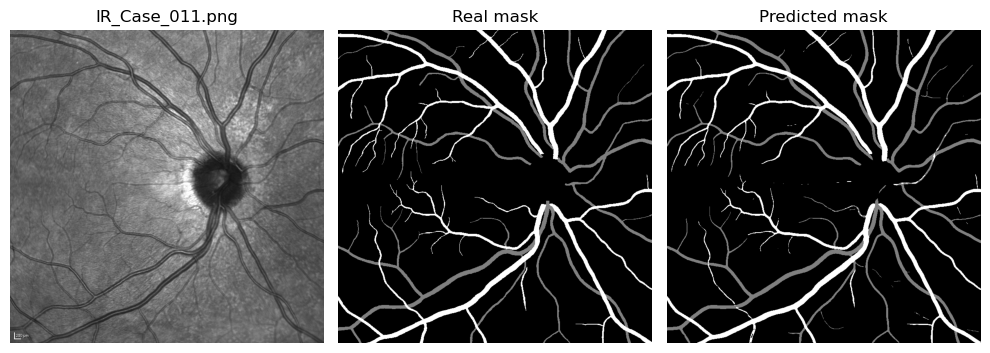

🖼️  Image : IR_Case_034.png


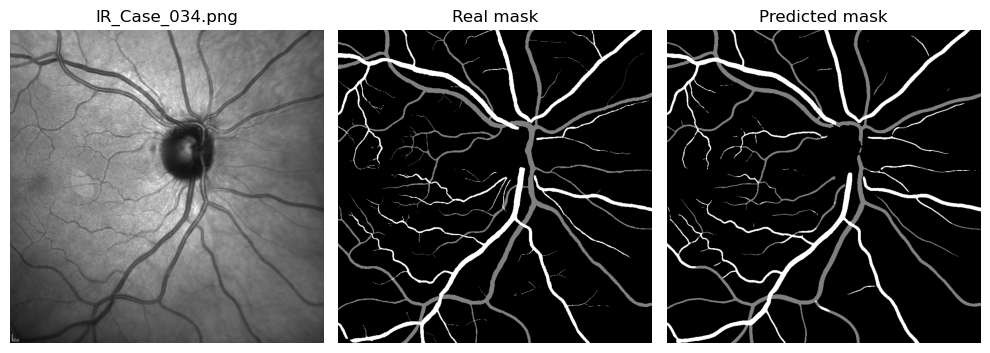

🖼️  Image : IR_Case_026.png


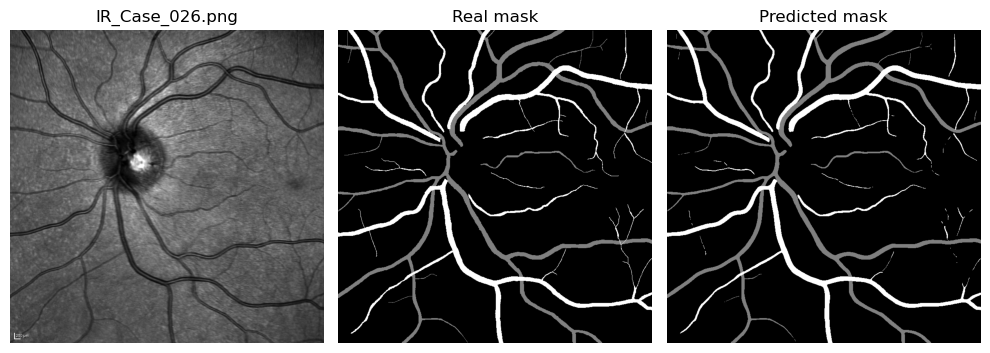

In [27]:
random.seed(42)
sample_names = random.sample(common_names, 5)

# ----- Visualisation -----
for idx, name in enumerate(sample_names):

    img  = load_img(img_dict[name])
    gt   = load_mask(gt_dict[name])
    pred = load_mask(pred_dict[name])

    print(f"🖼️  Image : {name}")

    # Figure individuelle
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))

    ax[0].imshow(img, cmap="gray")
    ax[0].set_title(f"{name}")
    ax[0].axis("off")

    ax[1].imshow(gt, cmap="gray", vmin=0, vmax=255)
    ax[1].set_title("Real mask")
    ax[1].axis("off")

    ax[2].imshow(pred, cmap="gray", vmin=0, vmax=255)
    ax[2].set_title("Predicted mask")
    ax[2].axis("off")

    plt.tight_layout()

    # 📌 Sauvegarde : visu_5_samples/IR_Case_xx.png
    save_path = save_dir_5_samples / f"{idx:02d}_{name}"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")

    plt.show()

# Table results

In [16]:
# =========================
#  UTILS: init buffers
# =========================
def init_confmat_sums():
    return {
        "TP": {CLASS_ARTERY:0, CLASS_VEIN:0},
        "FP": {CLASS_ARTERY:0, CLASS_VEIN:0},
        "FN": {CLASS_ARTERY:0, CLASS_VEIN:0},
        "TN": {CLASS_ARTERY:0, CLASS_VEIN:0},
        "N":  0
    }

def init_auc_buffers():
    return {
        CLASS_ARTERY: {"y_true":[], "y_score":[]},
        CLASS_VEIN:   {"y_true":[], "y_score":[]},
    }

# =========================
#  UTILS: update confmat
# =========================
def update_confmat_sums(sums, pred, target):
    assert pred.shape == target.shape
    sums["N"] += pred.size
    for cls in VESSEL_CLASSES:
        p = (pred == cls)
        t = (target == cls)

        sums["TP"][cls] += np.logical_and(p, t).sum()
        sums["FP"][cls] += np.logical_and(p, ~t).sum()
        sums["FN"][cls] += np.logical_and(~p, t).sum()
        sums["TN"][cls] += np.logical_and(~p, ~t).sum()

# =========================
#  UTILS: update AUC buffers
# =========================
def update_auc_buffers(buffers, pred, target):
    for cls in VESSEL_CLASSES:
        y_true = (target == cls).astype(np.uint8).ravel()
        y_score = (pred == cls).astype(np.float32).ravel()   # 0/1 score
        buffers[cls]["y_true"].append(y_true)
        buffers[cls]["y_score"].append(y_score)

# =========================
#  MÉTRIQUES PAR CLASSE
# =========================
def compute_per_class_metrics_from_confmat(sums, cls):
    TP = sums["TP"][cls]
    FP = sums["FP"][cls]
    FN = sums["FN"][cls]
    TN = sums["TN"][cls]
    eps = 1e-7

    acc  = (TP + TN) / max(TP + FP + FN + TN, eps)
    prec = TP / max(TP + FP, eps)
    rec  = TP / max(TP + FN, eps)
    spec = TN / max(TN + FP, eps)
    dice = (2 * TP) / max(2*TP + FP + FN, eps)
    iou  = TP / max(TP + FP + FN, eps)

    return {
        "accuracy":   acc,
        "precision":  prec,
        "recall":     rec,
        "specificity":spec,
        "dice":       dice,
        "iou":        iou,
    }

def compute_auc_for_class(buffers, cls):
    y_true  = np.concatenate(buffers[cls]["y_true"])
    y_score = np.concatenate(buffers[cls]["y_score"])

    # Cas où classe absente dans toute l'image
    if y_true.mean() == 0 or y_true.mean() == 1:
        return float("nan")

    try:
        return float(roc_auc_score(y_true, y_score))
    except:
        return float("nan")


# =========================
#   CHARGE GT + PRED
# =========================
def load_mask(path):
    return np.array(Image.open(path))

gt_dict   = {f.name: f for f in GT_DIR.glob("*.png")}
pred_dict = {f.name: f for f in PRED_DIR.glob("*.png")}

common_names = sorted(set(gt_dict.keys()) & set(pred_dict.keys()))


# =========================
#   ÉVALUATION SUR TOUTES LES IMAGES
# =========================
conf_sums_val = init_confmat_sums()
auc_buf_val   = init_auc_buffers()

for name in common_names:
    gt   = load_mask(gt_dict[name])
    pred = load_mask(pred_dict[name])

    update_confmat_sums(conf_sums_val, pred, gt)
    update_auc_buffers(auc_buf_val, pred, gt)


# =========================
#   MÉTRIQUES PAR CLASSE
# =========================
results = {}

for cls, name in zip(VESSEL_CLASSES, ["Artery", "Vein"]):
    m = compute_per_class_metrics_from_confmat(conf_sums_val, cls)
    m["auc"] = compute_auc_for_class(auc_buf_val, cls)
    results[name] = m

# =========================
#   MOYENNE ARTERY + VEIN
# =========================
avg_metrics = {
    metric: np.nanmean([results["Artery"][metric], results["Vein"][metric]])
    for metric in results["Artery"]
}
results["Average (A+V)"] = avg_metrics

# =========================
#   AFFICHAGE EN TABLEAU
# =========================
df = pd.DataFrame(results).T.round(4)
print("\n=== Résultats globaux (sur toutes les images prédictes) ===\n")
display(df.style.format("{:.4f}"))


=== Résultats globaux (sur toutes les images prédictes) ===



,accuracy,precision,recall,specificity,dice,iou,auc
Artery,0.9890,0.9262,0.9234,0.9942,0.9248,0.8601,0.9588
Vein,0.9909,0.9264,0.9057,0.9959,0.9159,0.8449,0.9508
Average (A+V),0.9900,0.9263,0.9145,0.9950,0.9204,0.8525,0.9548


# Visual information

Found 23 mask pairs.


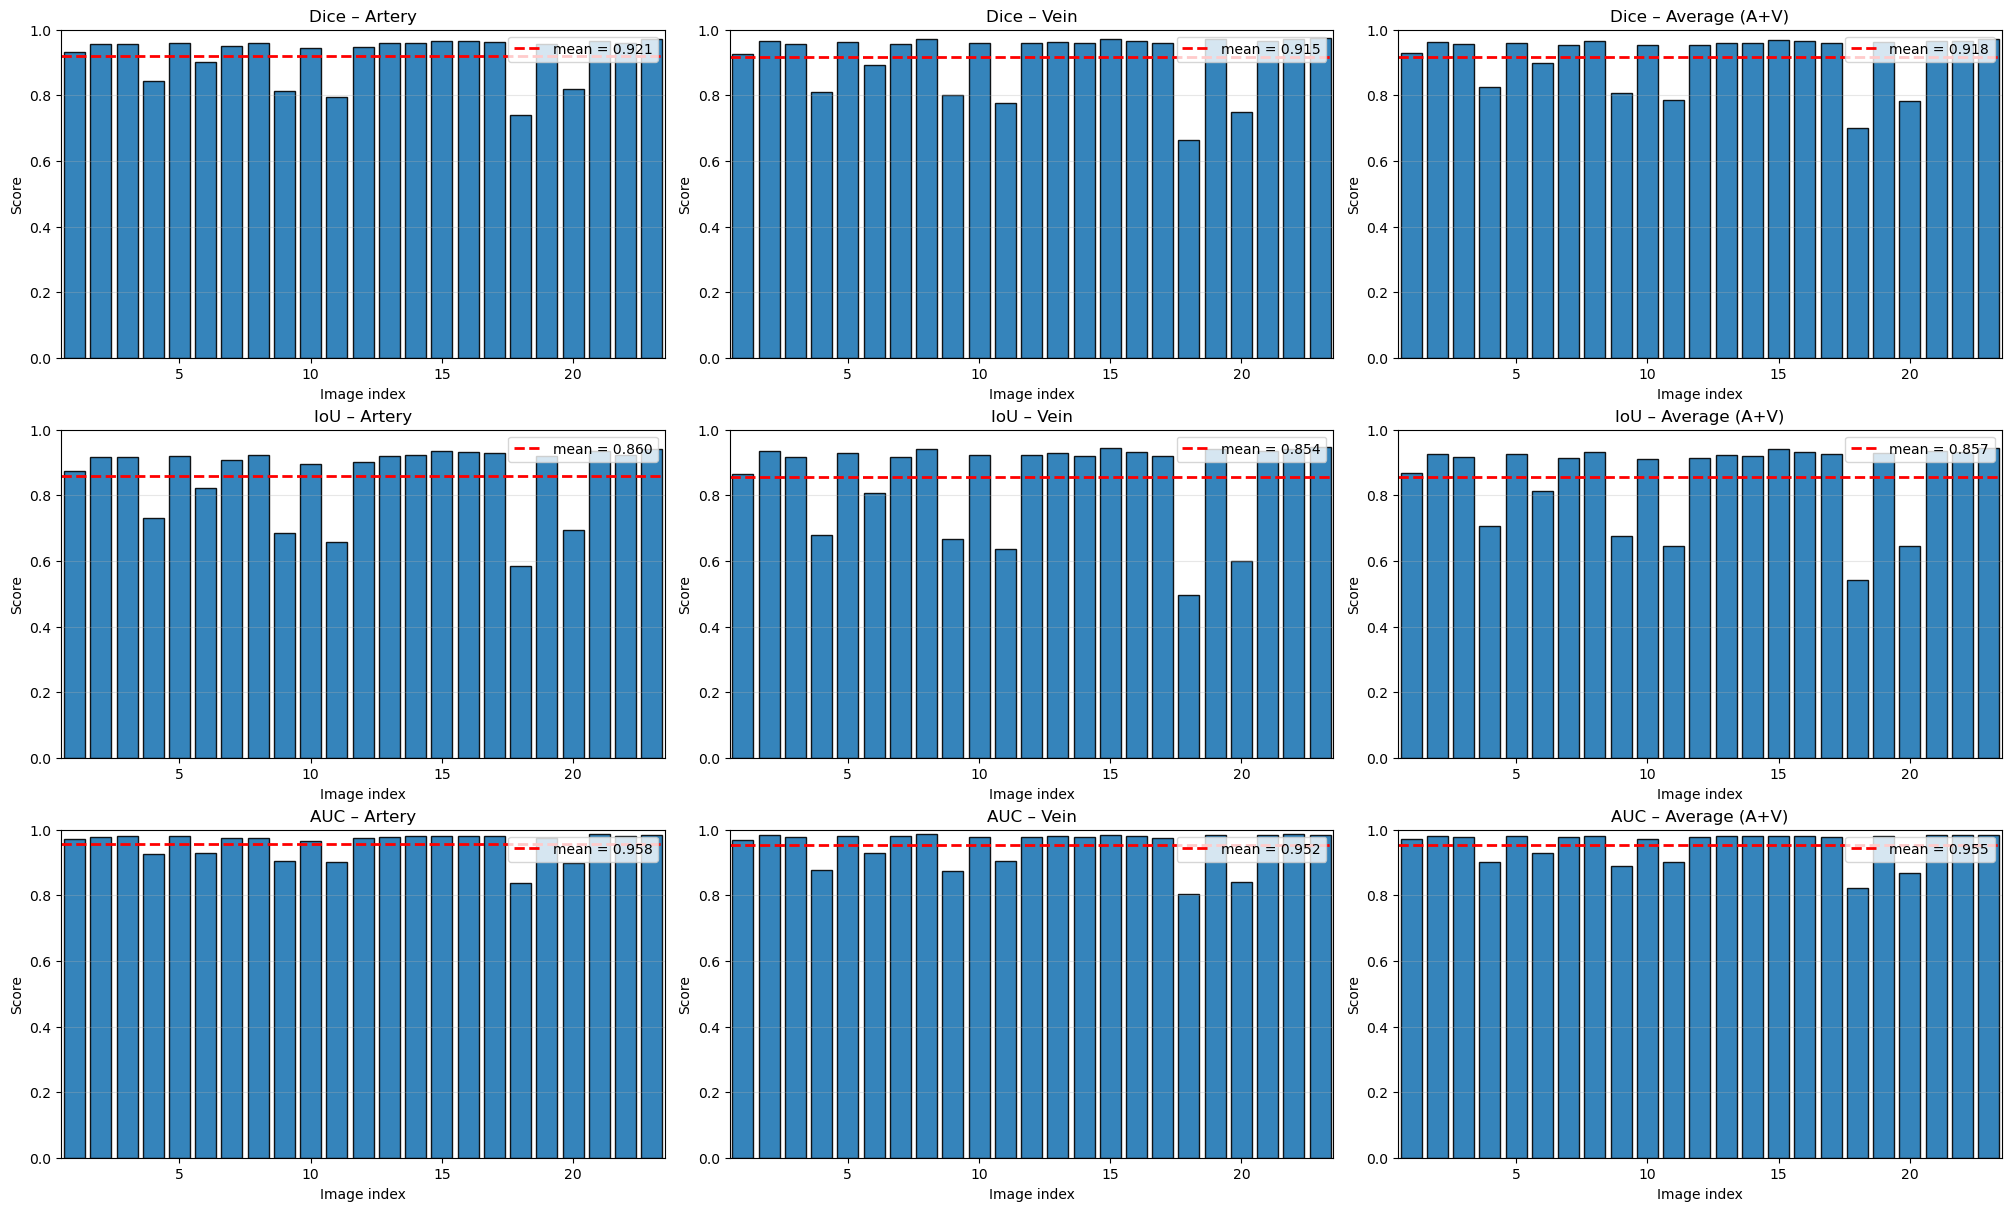

In [18]:
# =========================
#   CONFIG CLASSES (PNG)
# =========================
CLASS_ARTERY = 255   # blanc
CLASS_VEIN   = 128   # gris
VESSEL_CLASSES = [CLASS_ARTERY, CLASS_VEIN]

# =========================
#   HELPERS
# =========================
def load_mask(path):
    return np.array(Image.open(path))

def dice_per_image(pred, target, cls):
    eps = 1e-7
    p = (pred == cls).astype(np.float32)
    t = (target == cls).astype(np.float32)
    inter = (p * t).sum()
    denom = p.sum() + t.sum()
    return float((2.0 * inter) / (denom + eps))

def iou_per_image(pred, target, cls):
    eps = 1e-7
    p = (pred == cls)
    t = (target == cls)
    inter = np.logical_and(p, t).sum()
    union = np.logical_or(p, t).sum()
    return float(inter / (union + eps))

def auc_per_image(pred, target, cls):
    y_score = (pred == cls).astype(np.float32).ravel()
    y_true  = (target == cls).astype(np.uint8).ravel()

    pos = (y_true == 1).sum()
    neg = (y_true == 0).sum()
    if pos == 0 or neg == 0:
        return float("nan")

    try:
        return float(roc_auc_score(y_true, y_score))
    except Exception:
        return float("nan")


# =========================
#   LISTE DES FICHIERS COMMUNS
# =========================
gt_dict   = {f.name: f for f in GT_DIR.glob("*.png")}
pred_dict = {f.name: f for f in PRED_DIR.glob("*.png")}
common    = sorted(set(gt_dict.keys()) & set(pred_dict.keys()))

print(f"Found {len(common)} mask pairs.")


# =========================
#   COLLECT PER-IMAGE METRICS
# =========================
artery_dice_list, vein_dice_list, avg_dice_list = [], [], []
artery_iou_list,  vein_iou_list,  avg_iou_list  = [], [], []
artery_auc_list,  vein_auc_list,  avg_auc_list  = [], [], []

for name in common:
    gt   = load_mask(gt_dict[name])
    pred = load_mask(pred_dict[name])

    # Dice
    a_d = dice_per_image(pred, gt, CLASS_ARTERY)
    v_d = dice_per_image(pred, gt, CLASS_VEIN)
    artery_dice_list.append(a_d)
    vein_dice_list.append(v_d)
    avg_dice_list.append(np.nanmean([a_d, v_d]))

    # IoU
    a_i = iou_per_image(pred, gt, CLASS_ARTERY)
    v_i = iou_per_image(pred, gt, CLASS_VEIN)
    artery_iou_list.append(a_i)
    vein_iou_list.append(v_i)
    avg_iou_list.append(np.nanmean([a_i, v_i]))

    # AUC
    a_auc = auc_per_image(pred, gt, CLASS_ARTERY)
    v_auc = auc_per_image(pred, gt, CLASS_VEIN)
    artery_auc_list.append(a_auc)
    vein_auc_list.append(v_auc)
    avg_auc_list.append(np.nanmean([a_auc, v_auc]))


# =========================
#   BAR PLOTS
# =========================
def plot_bars_one_metric(ax, values, title):
    values = np.array(values, dtype=float)
    n = len(values)
    x = np.arange(1, n+1)

    ax.bar(x, values, color="#1f77b4", edgecolor="black", alpha=0.9)

    m = np.nanmean(values)
    ax.axhline(m, color="red", linestyle="--", linewidth=2, label=f"mean = {m:.3f}")

    ax.set_ylim(0, 1)
    ax.set_xlim(0.5, n + 0.5)
    ax.set_xlabel("Image index")
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3)
    ax.legend(loc="upper right")


fig, axes = plt.subplots(3, 3, figsize=(20, 12), constrained_layout=True)

# Row 1 — Dice
plot_bars_one_metric(axes[0,0], artery_dice_list, "Dice – Artery")
plot_bars_one_metric(axes[0,1], vein_dice_list,   "Dice – Vein")
plot_bars_one_metric(axes[0,2], avg_dice_list,    "Dice – Average (A+V)")

# Row 2 — IoU
plot_bars_one_metric(axes[1,0], artery_iou_list, "IoU – Artery")
plot_bars_one_metric(axes[1,1], vein_iou_list,   "IoU – Vein")
plot_bars_one_metric(axes[1,2], avg_iou_list,    "IoU – Average (A+V)")

# Row 3 — AUC
plot_bars_one_metric(axes[2,0], artery_auc_list, "AUC – Artery")
plot_bars_one_metric(axes[2,1], vein_auc_list,   "AUC – Vein")
plot_bars_one_metric(axes[2,2], avg_auc_list,    "AUC – Average (A+V)")

plt.show()
